   # Reference : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## We are going to develop an LSTM model for relative humidity prediction

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt 
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas import concat
import matplotlib  

In [3]:
col=['DATE','TIME','CO_GT','PT08_S1_CO','NMHC_GT','C6H6_GT','PT08_S2_NMHC',
     'NOX_GT','PT08_S3_NOX','NO2_GT','PT08_S4_NO2','PT08_S5_O3','T','RH','AH']

#define number of columns from csv
use=list(np.arange(len(col)))

#read the data from csv
data=pd.read_csv('./AirQualityUCI.csv', na_values=-200)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# chaanging data types to date
data['Date'] = pd.to_datetime(data['Date'])
print (data['Date'].head(3))

0   2004-03-10
1   2004-03-10
2   2004-03-10
Name: Date, dtype: datetime64[ns]


In [5]:
#setting date as an index
data = data.set_index('Date')

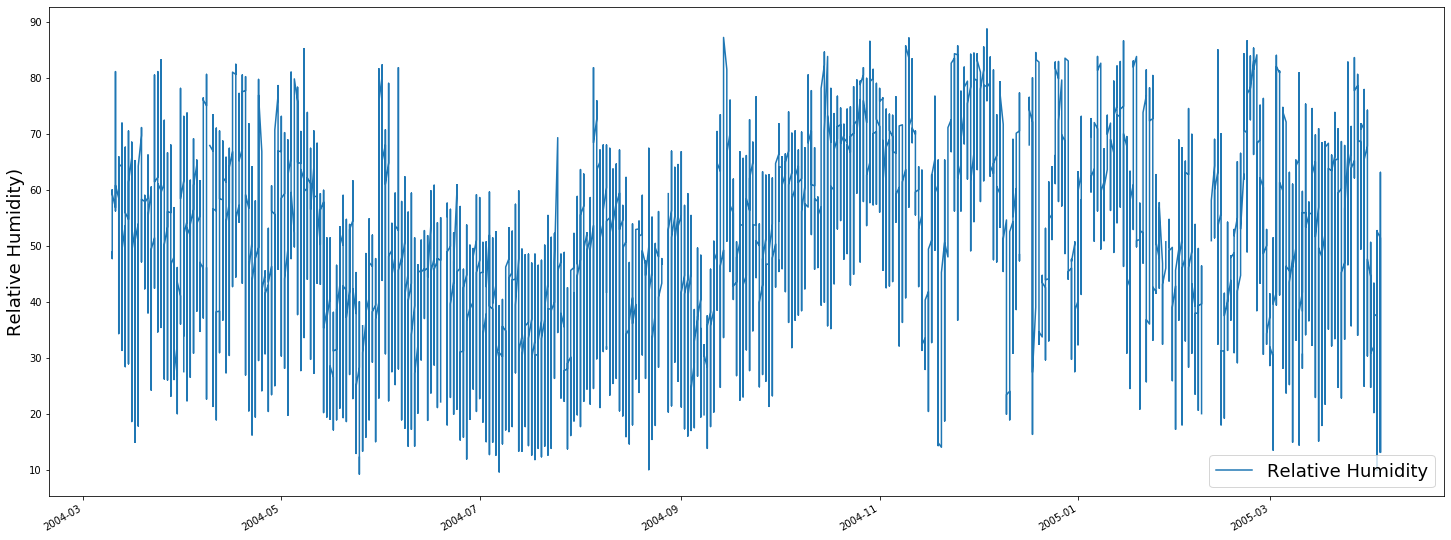

In [6]:
plt.figure(figsize=(25,10))


plt.plot( data['RH'], label='Relative Humidity')

plt.ylabel('Relative Humidity)', fontsize=18)

plt.legend(loc='lower right', fontsize=18)
plt.gcf().autofmt_xdate()


plt.show()

In [7]:
data.head()

,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,,
2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [8]:
list(data.columns)

['Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [9]:
data.shape

(9357, 14)

In [10]:
data.isnull().sum(axis = 0)

Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [11]:
data = data[['RH',
             'PT08.S1(CO)',
             'C6H6(GT)',
             'PT08.S2(NMHC)',
             'PT08.S3(NOx)',
             'PT08.S4(NO2)',
             'PT08.S5(O3)',
             'T',
             'AH']]

In [12]:
data = data.dropna()

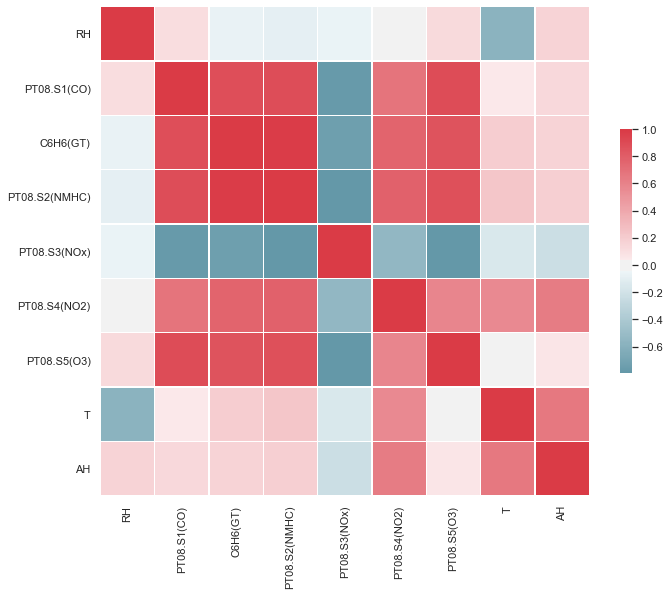

In [13]:
import seaborn as sns
sns.set(style="white")
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
Correlation  = data.corr()['RH'].abs().sort_values(ascending=False)
Correlation

RH               1.000000
T                0.578621
AH               0.167971
PT08.S5(O3)      0.124956
PT08.S1(CO)      0.114606
PT08.S2(NMHC)    0.090380
C6H6(GT)         0.061681
PT08.S3(NOx)     0.056740
PT08.S4(NO2)     0.032188
Name: RH, dtype: float64

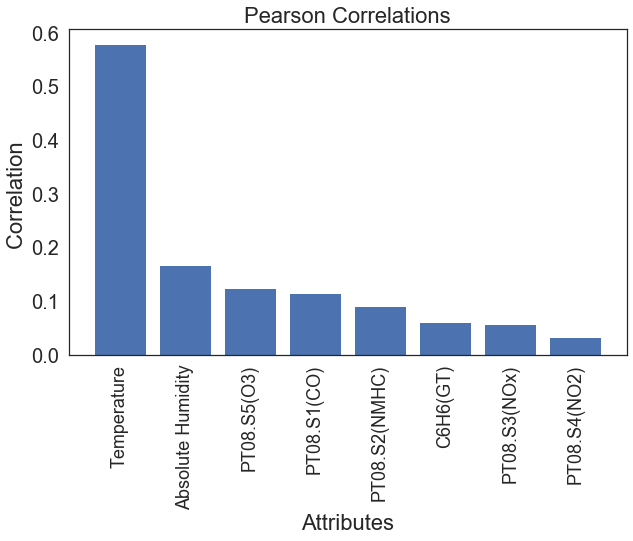

In [15]:
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)


names = [
'Temperature',
'Absolute Humidity',    
'PT08.S5(O3)',
 'PT08.S1(CO)',
'PT08.S2(NMHC)',
'C6H6(GT)',    
 'PT08.S3(NOx)',
    'PT08.S4(NO2)']
    



x_pos = [i for i, _ in enumerate(names)]


plt.figure(figsize=(10, 6))
# Create plot title
plt.title("Pearson Correlations",fontsize=22)




pyplot.bar([x for x in range(len(Correlation[1:13]))], Correlation[1:13])
plt.xticks(x_pos, names, rotation=90,fontsize=18)


plt.xlabel('Attributes', fontsize=22)
plt.ylabel('Correlation ', fontsize=22)
pyplot.show()



In [16]:
data.shape

(8991, 9)

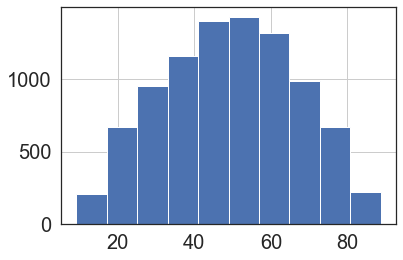

In [17]:
data['RH'].hist()
plt.show()

In [18]:
data['RH'].mean()

49.2342008675342

In [19]:
#data['CH4 (m3/day)'].fillna(data['CH4 (m3/day)'].mean(), inplace=True)

In [20]:
data.columns

Index(['RH', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH'],
      dtype='object')

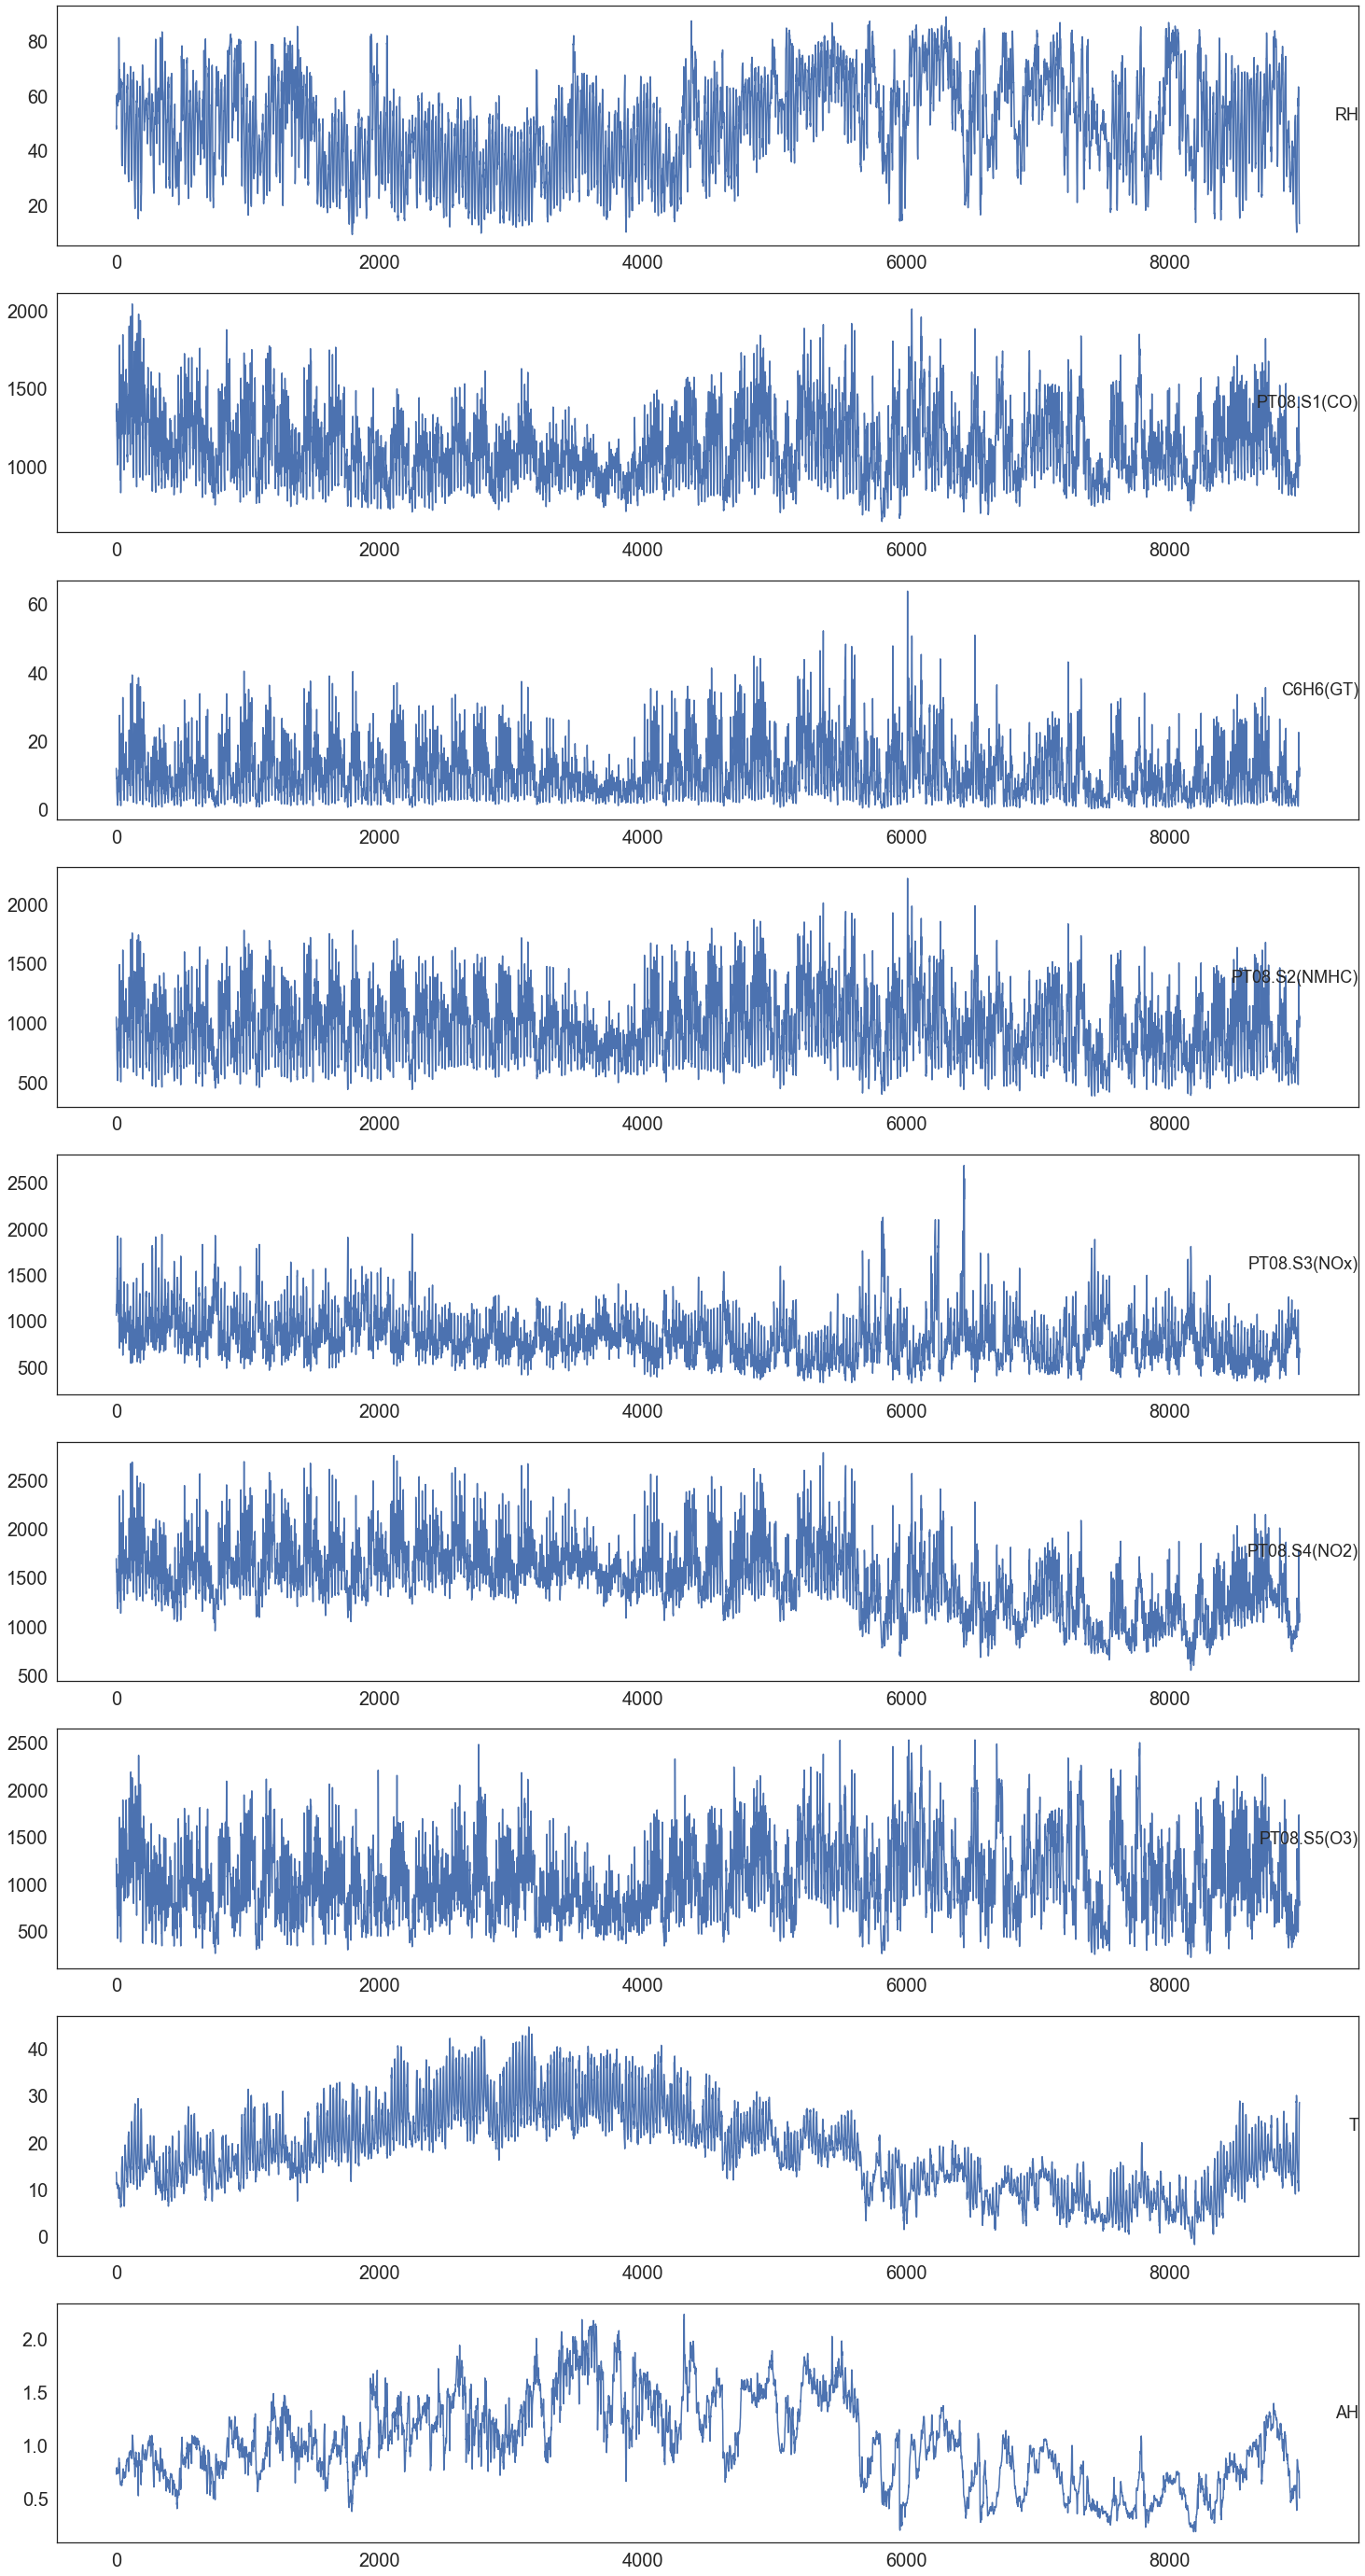

In [21]:
values = data.values
groups = [0, 1, 2, 3, 4, 5,6,7,8]
i = 1
pyplot.figure(figsize=(25,50))
for group in groups:
	pyplot.subplot( len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(data.columns[group], y=0.5, loc='right',fontsize=18 )
	i += 1
pyplot.show()

In [22]:
#we need to prepare the data for LSTM. 
#We intend to predict the relative humidity for the next hour based on the variables over the last week (168 hours)

def making_supervised(data, number_input=1, number_output=1, dropnan=True):
	number_variables = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(number_input, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(number_variables)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, number_output):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(number_variables)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(number_variables)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [23]:
values = data.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = making_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[ 10,11,12,13,14,15,16,17]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.499371   0.511845   0.185535   0.362097   0.310885   0.513040   
2   0.484277   0.463029   0.146226   0.312398   0.360864   0.453237   
3   0.563522   0.541996   0.139937   0.303659   0.346463   0.451439   
4   0.638994   0.523331   0.143082   0.308575   0.326133   0.464478   
5   0.633962   0.448672   0.100629   0.247406   0.373994   0.422212   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.454822   0.333333   0.280066  0.484277  
2   0.326238   0.326882   0.264282  0.563522  
3   0.370547   0.296774   0.276352  0.638994  
4   0.426586   0.277419   0.294190  0.633962  
5   0.386186   0.281720   0.295216  0.628931  


In [24]:
0.8 * len(values)

7192.8

In [25]:
values = reframed.values
# selecting 80% (7192) of dataset for training
train_hours = 7192
#split into training dataset and testing dataset
train_dataset = values[:train_hours, :]
test_dataset = values[train_hours:, :]
# split into input and outputs
X_train, y_train = train_dataset[:, :-1], train_dataset[:, -1]
X_test, y_test = test_dataset[:, :-1], test_dataset[:, -1]

In [26]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7192, 1, 9) (7192,) (1798, 1, 9) (1798,)


In [27]:
# Developing an LSTM with Keras Sequential model
model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# fit network
history = model.fit(X_train, y_train, epochs=200, batch_size=50, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 7192 samples, validate on 1798 samples
Epoch 1/200
 - 1s - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 2/200
 - 0s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/200
 - 0s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/200
 - 0s - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/200
 - 0s - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 9/200
 - 0s - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 10/200
 - 0s - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0044 - val_mse

Epoch 90/200
 - 1s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 91/200
 - 1s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 92/200
 - 1s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 93/200
 - 1s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 94/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 95/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 96/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 97/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 98/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 99/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 100/200
 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 101/200
 - 0s - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0

Epoch 186/200
 - 0s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 187/200
 - 0s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 188/200
 - 0s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 189/200
 - 0s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 190/200
 - 1s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 191/200
 - 1s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 192/200
 - 1s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 193/200
 - 1s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 194/200
 - 1s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 195/200
 - 1s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 196/200
 - 1s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 197/200
 - 1s - loss: 0.0032 - mse: 0.0032 - val

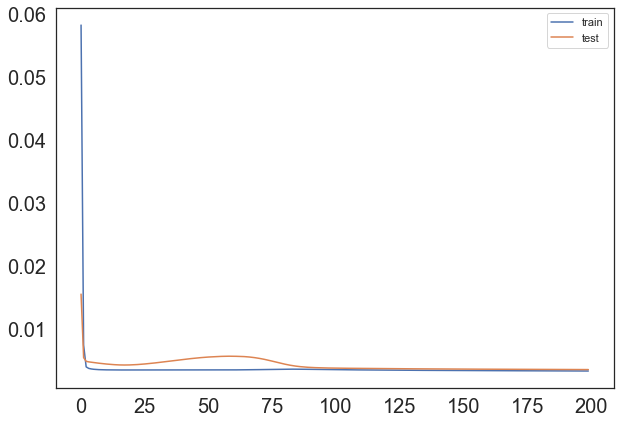

In [28]:
pyplot.figure(figsize=(10,7))

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
#making predictions
predicts = model.predict(X_test)
X_test= X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
invert_predicts = concatenate((predicts, X_test[:, 1:]), axis=1)
invert_predicts = scaler.inverse_transform(invert_predicts)
invert_predicts = invert_predicts[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
invert_actual_y = concatenate((y_test, X_test[:, 1:]), axis=1)
invert_actual_y = scaler.inverse_transform(invert_actual_y)
invert_actual_y = invert_actual_y[:,0]

In [30]:
MAE = mean_absolute_error(invert_actual_y, invert_predicts)
print('Test MAE: %.3f' % MAE)

RMSE = sqrt(mean_squared_error(invert_actual_y, invert_predicts))
print('Test RMSE: %.3f' % RMSE)

Test MAE: 3.371
Test RMSE: 4.680


In [31]:
print("R-Squared:", r2_score(invert_actual_y, invert_predicts))

R-Squared: 0.9196159162458115


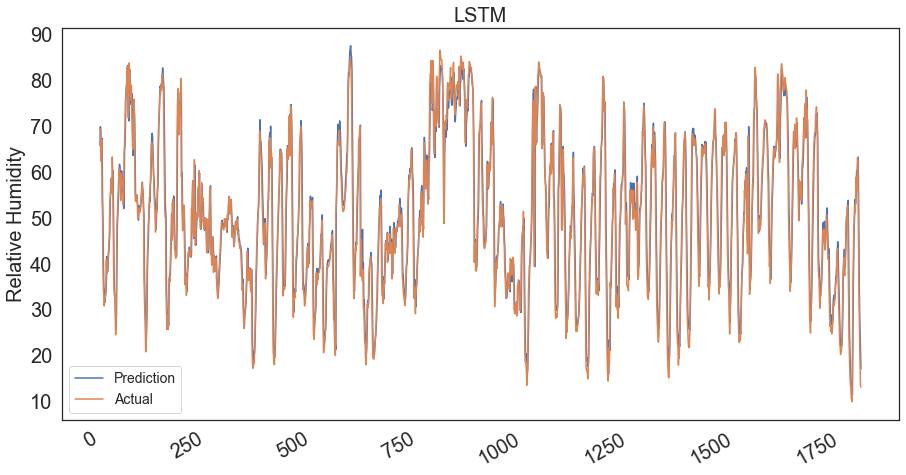

In [32]:
plt.figure(figsize=(15,8))

plt.plot(invert_predicts, label='Prediction')
plt.plot(invert_actual_y, label='Actual')

plt.ylabel('Relative Humidity', fontsize=20)
plt.legend(loc='lower left', fontsize=14)
plt.title(label= 'LSTM', fontsize=20)
plt.gcf().autofmt_xdate()



plt.show()

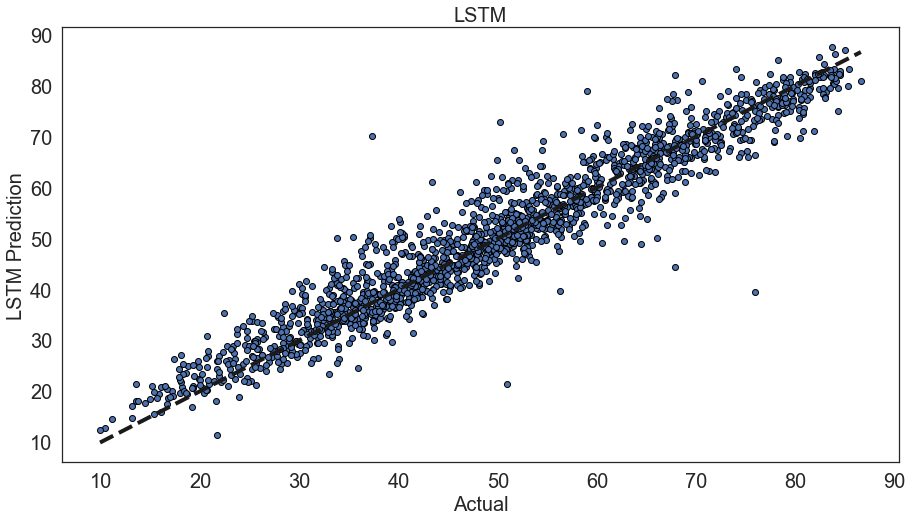

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(invert_actual_y, invert_predicts, edgecolors=(0, 0, 0))
ax.plot([invert_actual_y.min(), invert_actual_y.max()], [invert_actual_y.min(), invert_actual_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual', fontsize=20)
ax.set_ylabel('LSTM Prediction', fontsize=20)
plt.title(label= 'LSTM', fontsize=20)


plt.show()